## 1. Importación de librerías y carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, spearmanr, pearsonr, mode

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
data = pd.read_csv("../../datos/pre_processed.csv")
numericas = ["Administrative","Informational","ProductRelated", "Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]
data_numerica = data[numericas]

## Detección de atípicos

### IQR y Z-Scores

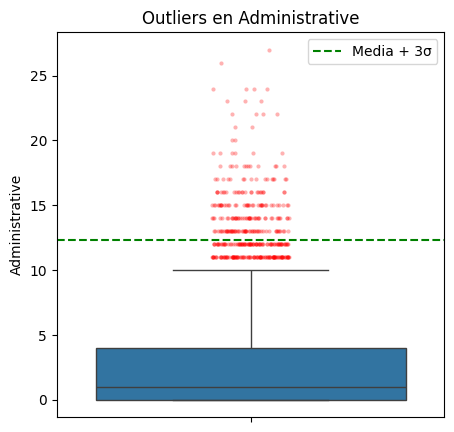

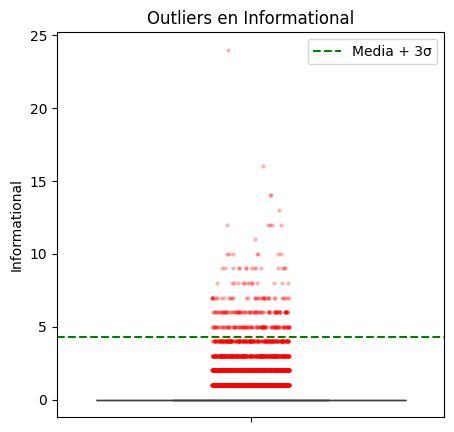

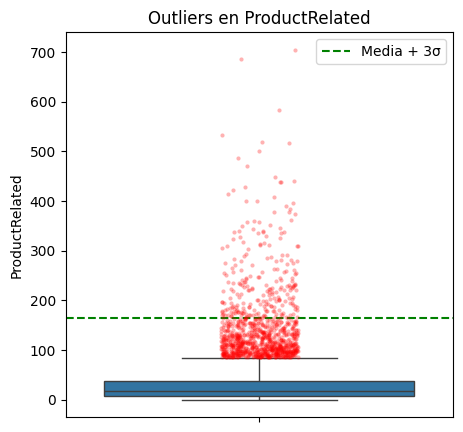

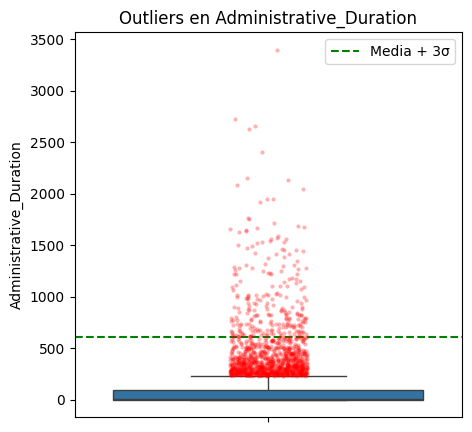

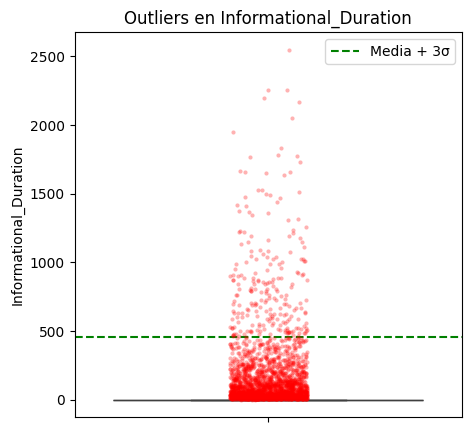

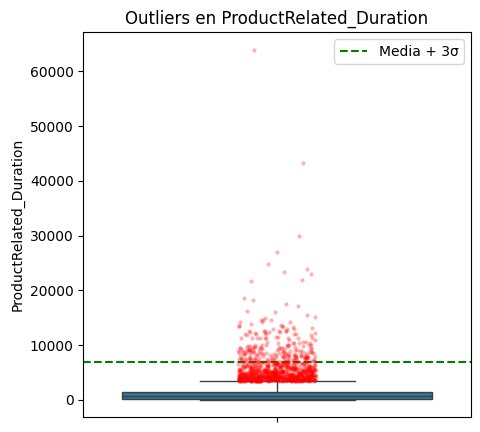

In [6]:
for col in data_numerica.columns:
  q1 = data_numerica[col].quantile(0.25)
  q3 = data_numerica[col].quantile(0.75)
  iqr = q3 - q1
  upper_bound = q3 + 1.5 * iqr
  z_3 = np.mean(data_numerica[col] + 3 * np.std(data_numerica[col]))
  outliers = data_numerica[data_numerica[col] > upper_bound][col]
  plt.figure(figsize=(5, 5))
  sns.boxplot(data_numerica[col],fliersize=0)
  sns.stripplot(y=outliers, color="red", jitter=True, alpha=0.3, size=3)
  plt.axhline(z_3, color='g', linestyle='--', label=f'Media + 3σ')
  plt.legend()
  plt.title(f"Outliers en {col}")
  plt.show()

Por IQR con Q3 + 1.5*IQR:
*   Debido a que todas las variables presentan densidades muy altas en valores bajos cercanos a cero, el límite superior para el cálculo de valores atípicos se hace muy bajo, por lo que hay una gran cantidad de valores por fuera. Para no etiquetar erroneamente algún valor como outlier, se hace necesario ajustar el cálculo del límite o usar una técnica por clustering.

Por Z-scores con Z>3:
*   Esta técnica muestra mas tolerancia que IQR, sin embargo, para la mayoría de variables permanecen fuera del rango una gran cantidad de datos con densidades considerables. Esto respalda la afirmación anterior de usar una técnica de clustering

### Isolation Forest

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numerica)
pca = PCA()
data_pca = pca.fit_transform(data_scaled)

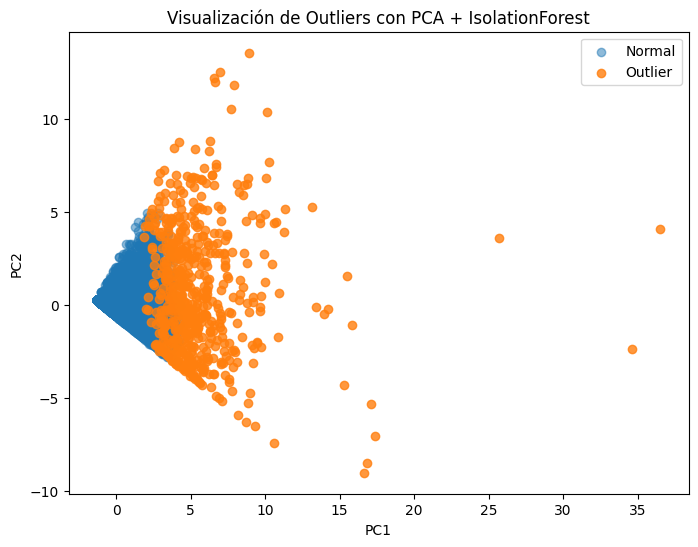

Número de outliers encontrados: 617


In [14]:
from sklearn.ensemble import IsolationForest


scaler = StandardScaler()
iso_data = data_numerica.copy()
data_scaled = scaler.fit_transform(iso_data)
iso = IsolationForest(contamination=0.05, random_state=42)
iso_data["outlier_iso"] = iso.fit_predict(data_scaled)


#PCA a 2 componentes para visualización
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[iso_data["outlier_iso"] == 1, 0], data_pca[iso_data["outlier_iso"] == 1, 1],
            label="Normal", alpha=0.5)
plt.scatter(data_pca[iso_data["outlier_iso"] == -1, 0], data_pca[iso_data["outlier_iso"] == -1, 1],
            label="Outlier", alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualización de Outliers con PCA + IsolationForest")
plt.legend()
plt.show()

print("Número de outliers encontrados:", np.sum(iso_data["outlier_iso"] == -1))


Luego de aplicar Isolation Forest se encuentran 617 registros atípicos, aproximadamente un 5% del total de registros.

Dado que la toma de muestras se realiza a través del software de manera uniforme y automática, los valores atípicos se podrían explicar por situaciones particulares de los usuarios en cada sesión, por ejemplo, un usuario que navega mientras se encuentra en una reunión, o con una conexión lenta, etc. Por lo tanto me parece correcto eliminar estos registros del dataset.

In [31]:
data_to_drop = data.copy()
data_to_drop

,Unnamed: 0,Administrative,Informational,ProductRelated,Administrative_Duration,Informational_Duration,ProductRelated_Duration,Weekend,VisitorType,Revenue
0,0,0,0,1,0.0,0.0,0.000000,False,Returning_Visitor,False
1,1,0,0,2,0.0,0.0,64.000000,False,Returning_Visitor,False
2,2,0,0,1,0.0,0.0,0.000000,False,Returning_Visitor,False
3,3,0,0,2,0.0,0.0,2.666667,False,Returning_Visitor,False
4,4,0,0,10,0.0,0.0,627.500000,True,Returning_Visitor,False
...,...,...,...,...,...,...,...,...,...,...
12325,12325,3,0,53,145.0,0.0,1783.791667,True,Returning_Visitor,False
12326,12326,0,0,5,0.0,0.0,465.750000,True,Returning_Visitor,False
12327,12327,0,0,6,0.0,0.0,184.250000,True,Returning_Visitor,False
12328,12328,4,0,15,75.0,0.0,346.000000,False,Returning_Visitor,False


In [32]:
data_to_drop = data_to_drop[(iso_data["outlier_iso"] == 1)]

In [34]:
data_to_drop.reset_index(inplace=True)

In [41]:
data_to_drop.drop(columns=["index","Unnamed: 0"],axis=1,inplace=True)

C:\Users\SEBAS\AppData\Local\Temp\ipykernel_15856\427436811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_drop.drop(columns=["index","Unnamed: 0"],axis=1,inplace=True)


In [42]:
data_to_drop.to_csv("../../datos/pre_processed_2.csv",index=False)